# Imports

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import copy
import os
import shutil

# Preprocess Data

In [13]:
# Set device
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Define data transformations
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
}

# Load the dataset
data_dir = './data/flowers_labeled'
dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# Split Dataset

In [14]:
# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply respective transformations
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# Create data loaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
class_names = dataset.classes

# Baseline Performance | Before Training

In [22]:
# Modify the ResNet18 model
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    # nn.Linear(num_ftrs, 512),
    # nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, len(class_names)),
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Evaluate the model on the test set
model_ft.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Bluebell       0.00      0.00      0.00         7
   Buttercup       0.00      0.00      0.00        14
  Colts Foot       0.00      0.00      0.00         8
     Cowslip       0.00      0.00      0.00        10
      Crocus       0.00      0.00      0.00         9
    Daffodil       0.00      0.00      0.00         7
       Daisy       0.00      0.00      0.00        11
   Dandelion       0.00      0.00      0.00         8
  Fritillary       0.00      0.00      0.00         4
        Iris       0.00      0.00      0.00         9
 Lily Valley       0.00      0.00      0.00         4
       Pansy       0.00      0.00      0.00         4
    Snowdrop       0.00      0.00      0.00         7
   Sunflower       0.00      0.00      0.00        13
   Tigerlily       0.08      0.11      0.10         9
       Tulip       0.00      0.00      0.00         5
  Windflower       0.07      0.12      0.09         8

    accuracy              

/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set 

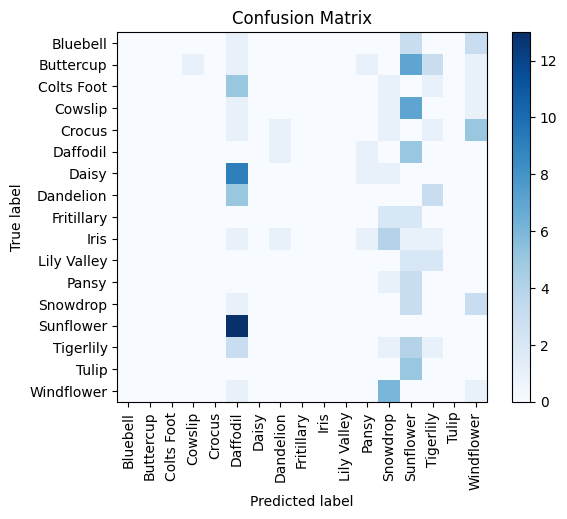

In [17]:
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation = 90)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Define Function to Train Model

In [21]:
# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save the new best weights to a file with a timestamp
                torch.save(best_model_wts, f'best_model_{epoch}_{best_acc}.pth')


    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

# Pass Hyper Parameters & Train Model

In [23]:
model_ft, train_loss, val_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 2.4548 Acc: 0.2513
val Loss: 1.6954 Acc: 0.6544
Epoch 1/9
----------
train Loss: 1.4243 Acc: 0.6898
val Loss: 1.0014 Acc: 0.8456
Epoch 2/9
----------
train Loss: 0.9051 Acc: 0.8559
val Loss: 0.6872 Acc: 0.8897
Epoch 3/9
----------
train Loss: 0.6325 Acc: 0.9001
val Loss: 0.5414 Acc: 0.9154
Epoch 4/9
----------
train Loss: 0.5310 Acc: 0.9180
val Loss: 0.4581 Acc: 0.9081
Epoch 5/9
----------
train Loss: 0.4375 Acc: 0.9295
val Loss: 0.4033 Acc: 0.9228
Epoch 6/9
----------
train Loss: 0.3830 Acc: 0.9285
val Loss: 0.3609 Acc: 0.9265
Epoch 7/9
----------
train Loss: 0.3217 Acc: 0.9495
val Loss: 0.3496 Acc: 0.9338
Epoch 8/9
----------
train Loss: 0.3354 Acc: 0.9464
val Loss: 0.3394 Acc: 0.9412
Epoch 9/9
----------
train Loss: 0.3400 Acc: 0.9527
val Loss: 0.3326 Acc: 0.9449


# Plot Training and Validation Loss Curves

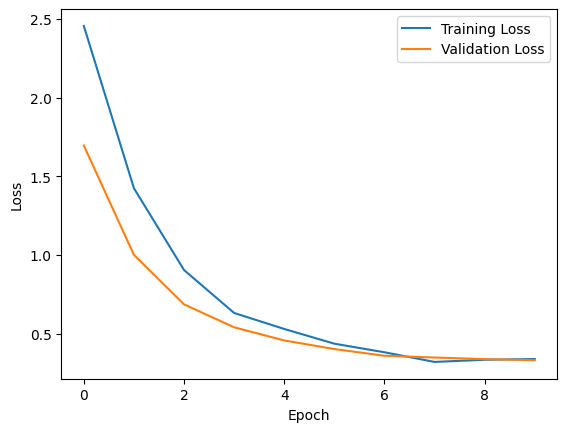

In [24]:
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()